In [1]:
# python -m pip install geopy
# python -m pip install geopandas


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
# import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
df = pd.read_csv('fp-historical-wildfire-data-2006-2021.csv')

# Columns being used

# Most Vunerable FSA regions in Alberta

1.  **fire_year** : Aligns with wildfire seasons and is very consistent. If fire start date and fire extinguished dates are different years then it is confusing and complex to determine which year the fire is.

2.  **size_class** : crucial for assesing severity of wildfires.

3.  **Fire Location Latitude & Longitude** : provide accurate geographical coordinates of fire.

4.  **fire_number** : contains information about the regions of fire occurance.

5.  **fire_start_date** : indicates fire start date (using it for duration of fire).

6.  **ex_fs_date** : fire extinguished date (using it for duration of fire).

7.  **current_size** : Indicates the final area burned by the wildfire.


## Most Vunerable FSA regions in Alberta (Data Analysis)

1.   Create bar plots of each regions (2006-2021) of fire using **fire_number**.

2.   Create interactive heat map using **fire_year**, **Fire Location Latitude & Longitude**, and **size_class**. We can specify the **fire_year**, **size_class**. *Possibly calculate average fire duration for each fire class*


## Data Cleaning (Most Vunerable FSA regions in Alberta)

In [5]:
# function to show class of fire size
def give_size_class(num):
    if num <= 0.1:
        return 'A'
    elif num <= 4.0:
        return 'B'
    elif num <= 40.0:
        return 'C'
    elif num <= 200:
        return 'D'
    else:
        return 'E'

In [6]:
df_map = df[["fire_year", "fire_location_latitude", "fire_location_longitude", "current_size" , "size_class", "fire_number", "fire_start_date", "ex_fs_date"]]

### Data Cleaning (Most Vunerable FSA regions in Alberta) - Cleaning Date Columns

In [7]:
# we wil use this function when we are cleaning dates for "fire_start_date" and "ex_fs_date"
# the function will return pd.NaT for null values.
def correct_date_string(date_str):
    # Check if the date_str is not a string (e.g., NaN represented as float)
    if not isinstance(date_str, str):
        return pd.NaT  # Return Not a Time for pandas

    # Split the date string into components
    parts = date_str.split('/')

    # Correct the month part
    month = parts[0]
    month = str(max(min(int(month), 12), 1)).zfill(2)  # Ensure month is between 01 and 12

    # Correct the day part
    day = parts[1]
    day = str(max(min(int(day), 31), 1)).zfill(2)  # Ensure day is between 01 and 31

    # Adjust the year part to use the last two digits
    year = parts[2].split(' ')[0]  # Extract year part only, ignoring time if present
    if len(year) == 4:  # If year is mistakenly input as 4 digits
        year = year[-2:]  # Use last two digits

    # Reconstruct the date string, including time part if present
    corrected_date_str = f"{month}/{day}/{year}"
    if len(parts[2].split(' ')) > 1:  # If there's a time part
        time_part = parts[2].split(' ')[1]  # Extract time part
        corrected_date_str += f" {time_part}"

    return corrected_date_str

In [8]:

# Now apply the corrected function
#df_map['fire_start_date'] = df_map['fire_start_date'].apply(correct_date_string)
#df_map['ex_fs_date'] = df_map['ex_fs_date'].apply(correct_date_string)

In [9]:
# Convert to datetime, errors='coerce' will handle any remaining issues by converting them to NaT
#df_map['fire_start_date'] = pd.to_datetime(df_map['fire_start_date'], format='%m/%d/%y %H:%M', errors='coerce')
#df_map['ex_fs_date'] = pd.to_datetime(df_map['ex_fs_date'], format='%m/%d/%y %H%M', errors='coerce')

In [10]:
df_map.loc[df_map['fire_start_date'].isna()].groupby(['size_class']).size().reset_index(name='count')
# it looks like we have null values in fire_start_date and these are the distribution of the size_class
# for now, we will keep them but when we use this column to calculate the duration we will remove these columns.

,size_class,count
0,A,611
1,B,6
2,C,2
3,E,1


In [11]:
  # checking bad date values
  #df_map.loc[df_map['fire_start_date']=='04/24/1021 12:00:00']

### Data Cleaning (Most Vunerable FSA regions in Alberta) - Mapping regions

In [12]:
# given region code, outputs the region
locations = {
    "C": "Calgary",
    "E": "Edson",
    "H": "High Level",
    "G": "Grande Prairie",
    "L": "Lac La Biche",
    "M": "Fort McMurray",
    "P": "Peace River",
    "R": "Rocky",
    "S": "Slave Lake",
    "W": "Whitecourt"
}

In [13]:
def map_region (fire_num) :
  # Extract the first letter from the code
    first_letter = fire_num[0]

    # Use the first letter to get the corresponding location from the dictionary
    # If the letter is not found, return a default value like "Unknown location"
    return locations.get(first_letter, "Unknown location")

In [14]:
# function that uses "location" to map the Regions using fire_number
df_map.loc[:, 'fire_regions'] = df_map['fire_number'].apply(map_region)

C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\4202445441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map.loc[:, 'fire_regions'] = df_map['fire_number'].apply(map_region)


In [15]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22914 entries, 0 to 22913
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fire_year                22914 non-null  int64  
 1   fire_location_latitude   22914 non-null  float64
 2   fire_location_longitude  22914 non-null  float64
 3   current_size             22914 non-null  float64
 4   size_class               22914 non-null  object 
 5   fire_number              22914 non-null  object 
 6   fire_start_date          22294 non-null  object 
 7   ex_fs_date               22914 non-null  object 
 8   fire_regions             22914 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


In [16]:
# create new data frame with fire_regions, fire_year, fire_count
df_regions_map = df_map[["fire_year","fire_regions"]]
df_regions_map = df_regions_map.groupby(["fire_year", "fire_regions"]).size().reset_index(name="fire_count")

## Plots (Most Vunerable FSA regions in Alberta)

Geographic map plot is going to be plotted via Power BI

### Plot - Distribution of Wildfire size classes by Region (2006-2021)

<Figure size 1200x800 with 0 Axes>

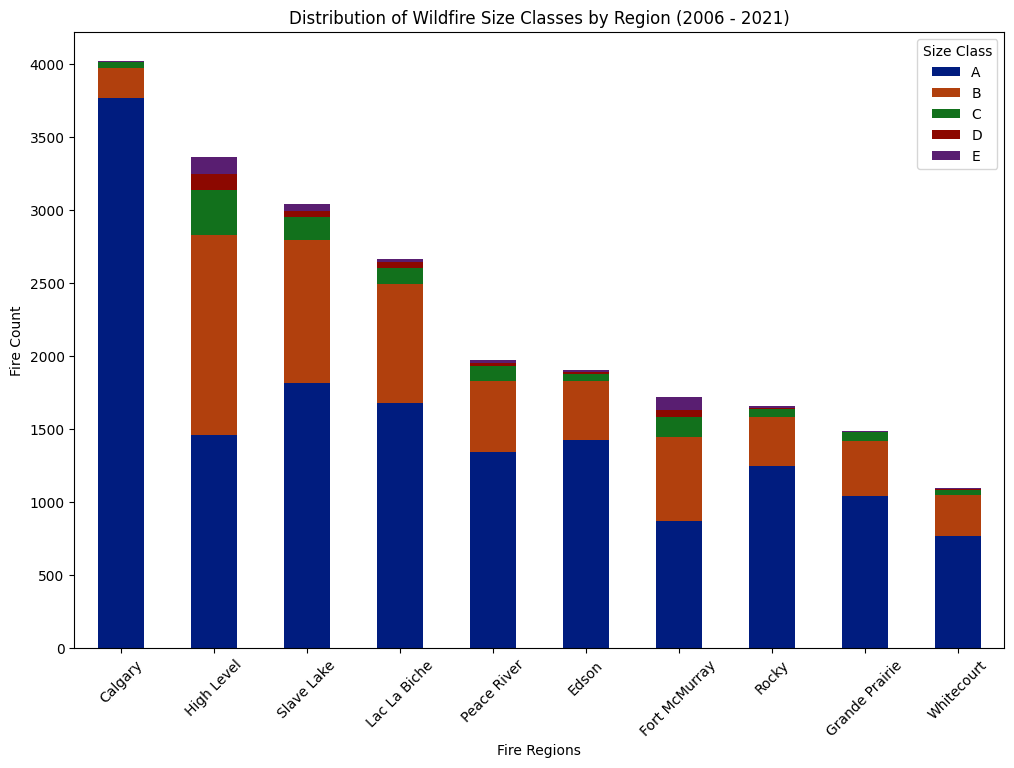

In [17]:
# Group by 'fire_regions' and 'size_class', then count the occurrences
grouped = df_map.groupby(['fire_regions', 'size_class']).size().reset_index(name='fire_count')

# Pivot the data for the stacked bar plot
pivot_df = grouped.pivot(index='fire_regions', columns='size_class', values='fire_count').fillna(0)

# Order the DataFrame rows by the total counts per region
pivot_df['total_count'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('total_count', ascending=False).drop('total_count', axis=1)

# Create a darker color palette for the different 'size_class'
palette = sns.color_palette("dark", len(pivot_df.columns))

# Create a stacked bar plot
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, color=palette, figsize=(12, 8))

# Add labels and title
plt.xlabel('Fire Regions')
plt.ylabel('Fire Count')
plt.title('Distribution of Wildfire Size Classes by Region (2006 - 2021)')

# Rotate the x-axis labels if they overlap
plt.xticks(rotation=45)

# Add legend for size_class
plt.legend(title='Size Class')

# Show the plot
plt.show()



In [18]:
pivot_df.reset_index()

size_class,fire_regions,A,B,C,D,E
0,Calgary,3763,209,40,3,2
1,High Level,1460,1365,313,110,114
2,Slave Lake,1813,981,157,44,44
3,Lac La Biche,1678,815,111,38,21
4,Peace River,1345,482,104,24,20
5,Edson,1423,404,48,14,12
6,Fort McMurray,869,573,138,48,91
7,Rocky,1243,342,50,11,11
8,Grande Prairie,1038,379,59,6,4
9,Whitecourt,770,275,40,4,6


### Plot - Most popular fire sizes count in Specified Region over 2006 to 2021

In [19]:
regions_list = pivot_df.reset_index()['fire_regions'].unique().tolist()

# look here to see which regions to choose **NOTE: THIS LINE OF CODE WILL NOT EDIT THE DATA FRAME IN ANY WAY!!
pd.DataFrame(regions_list, columns=['fire_regions'])

,fire_regions
0,Calgary
1,High Level
2,Slave Lake
3,Lac La Biche
4,Peace River
5,Edson
6,Fort McMurray
7,Rocky
8,Grande Prairie
9,Whitecourt


In [20]:
specified_region = regions_list[1]

### Plots - Total Fire Count of specified_region by Size Class (2006-2021)

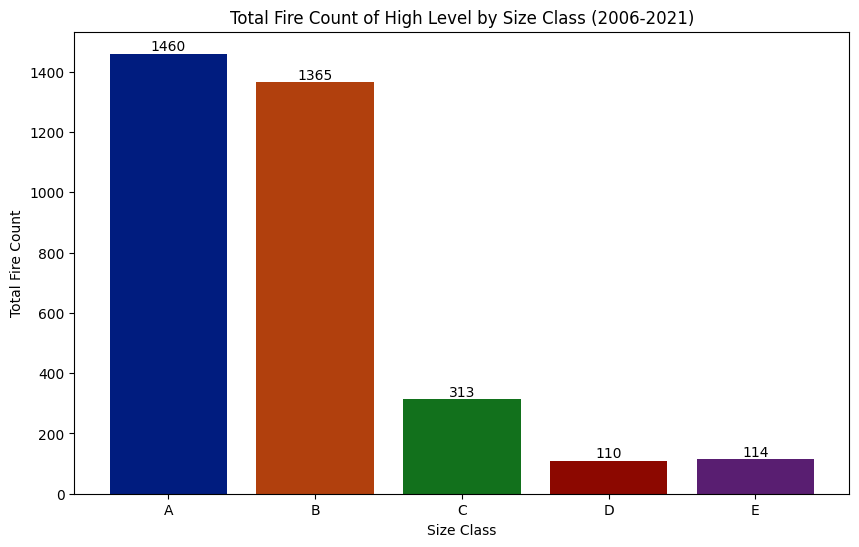

In [21]:
# Select fires within the specified region
df_current = df_map[df_map['fire_regions'] == specified_region]
df_current = df_current[['fire_year', 'size_class']]

# Group by fire_year and size_class, then count the number of fires
df_current = df_current.groupby(['size_class']).size().reset_index(name='fire_count').sort_values('size_class')

# Create a dark color palette
palette = sns.color_palette("dark", len(df_current['size_class']))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(df_current['size_class'], df_current['fire_count'], color=palette)

# Add count labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

# Add labels and title
plt.xlabel('Size Class')
plt.ylabel('Total Fire Count')
plt.title(f'Total Fire Count of {specified_region} by Size Class (2006-2021)')
# Show the plot
plt.show()


### Plot -  Alberta Fire Trend 2006-2021

In [22]:
tmp = df_regions_map.groupby('fire_year').sum().reset_index()
tmp.drop(columns=["fire_regions"],inplace=True)

Text(0.5, 1.0, 'Alberta Fire Trend 2006-2021')

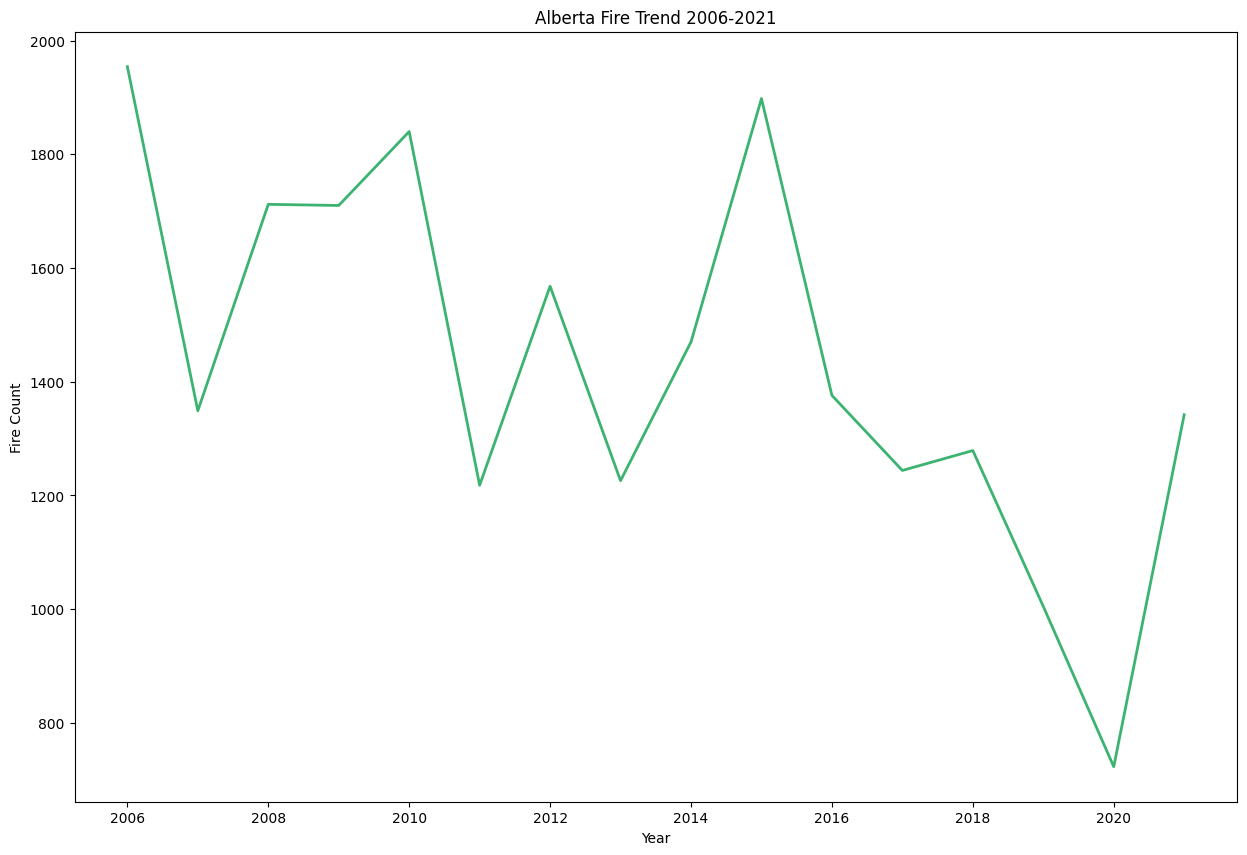

In [23]:
# Pivot the DataFrame to have years as the index and regions as the columns
# with fire counts as the values
plt.figure(figsize=(15, 10))
plt.plot(tmp['fire_year'], tmp['fire_count'], marker='', linewidth=2, color='mediumseagreen', label='Fire Count')
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fire Count')
plt.title('Alberta Fire Trend 2006-2021')

In [24]:
df_regions_map['fire_regions'].unique()

array(['Calgary', 'Edson', 'Fort McMurray', 'Grande Prairie',
       'High Level', 'Lac La Biche', 'Peace River', 'Rocky', 'Slave Lake',
       'Whitecourt'], dtype=object)

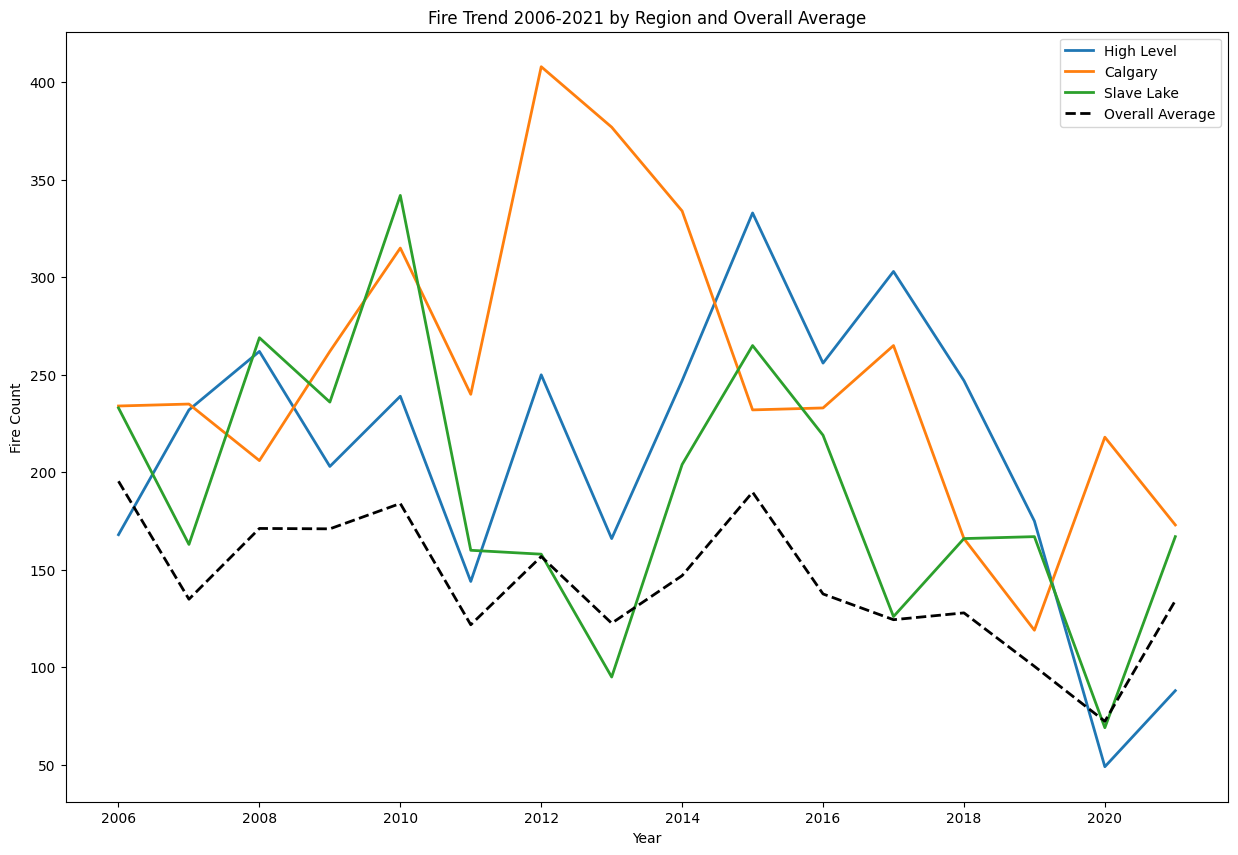

In [25]:
# Group by 'fire_year' and 'fire_regions', then calculate the mean fire counts
average_fire_counts = df_regions_map.groupby(['fire_year', 'fire_regions'])['fire_count'].mean().reset_index()

# If you want the overall average across all regions by year, group by 'fire_year' only and calculate the mean
overall_yearly_average = average_fire_counts.groupby('fire_year')['fire_count'].mean().reset_index()

# Example DataFrame columns: 'region', 'fire_year', 'fire_count'
regions_of_interest = ['High Level','Calgary', 'Slave Lake' ]  # Example regions

plt.figure(figsize=(15, 10))

# Loop through the regions of interest and plot each one
for region in regions_of_interest:
    # Filter the DataFrame for the current region
    filtered_df = df_regions_map[df_regions_map['fire_regions'] == region]
    
    # Aggregate fire counts by year if your data has multiple entries per year per region
    yearly_counts = filtered_df.groupby('fire_year')['fire_count'].sum().reset_index()
    
    # Plot each region's fire count trend
    plt.plot(yearly_counts['fire_year'], yearly_counts['fire_count'], marker='', linewidth=2, label=region)

# Plot the overall average fire count per year with a dotted line
plt.plot(overall_yearly_average['fire_year'], overall_yearly_average['fire_count'], 'k--', linewidth=2, label='Overall Average')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fire Count')
plt.title('Fire Trend 2006-2021 by Region and Overall Average')

# Add a legend to differentiate the regions and the overall average
plt.legend()

# Show the plot
plt.show()


In [26]:
regions_list

['Calgary',
 'High Level',
 'Slave Lake',
 'Lac La Biche',
 'Peace River',
 'Edson',
 'Fort McMurray',
 'Rocky',
 'Grande Prairie',
 'Whitecourt']

### Plot - fire class analysis in each region

In [27]:
# need to do separate geographial analysis using latitude and longitude based on region. 
# do analysis based on fire size class

### Plot - Fire Size Class yearly trend for specified_region

In [28]:
size_class_counts = df_map.groupby(['fire_regions', 'size_class']).size().reset_index(name='counts')

In [29]:
# look here to see which regions to choose **NOTE: THIS LINE OF CODE WILL NOT EDIT THE DATA FRAME IN ANY WAY!!
pd.DataFrame(regions_list, columns=['fire_regions'])

,fire_regions
0,Calgary
1,High Level
2,Slave Lake
3,Lac La Biche
4,Peace River
5,Edson
6,Fort McMurray
7,Rocky
8,Grande Prairie
9,Whitecourt


In [30]:
# select a region to inspect from regions_list
selected_region = regions_list[4]

### Plot - Yearly Trend of Wild Fires for selected_region by size class

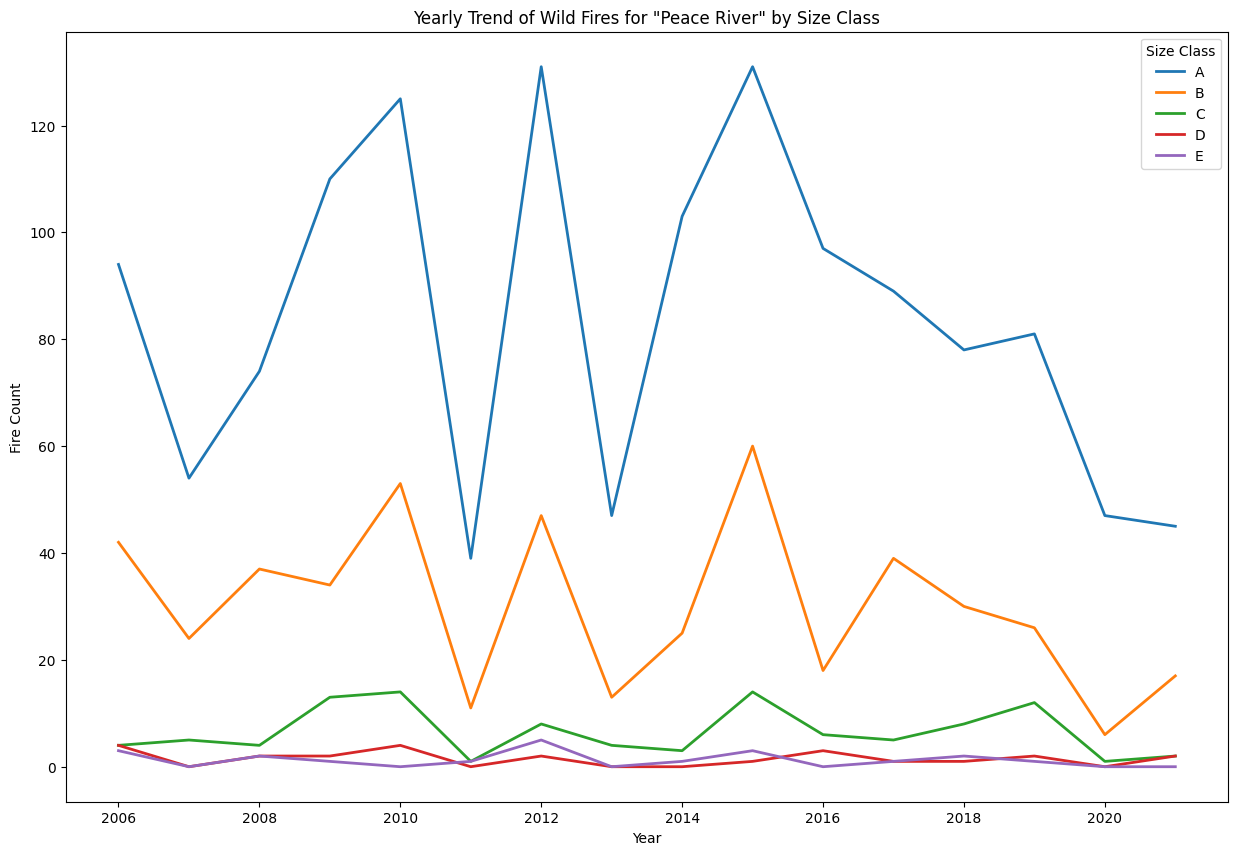

In [31]:
# select fires with specified region
df_current = df_map[df_map['fire_regions']==selected_region]
df_current = df_current[['fire_year','size_class']]
# groupby fire_year and size_class, then add column that counts the number of fire
df_current = df_current.groupby(['fire_year', 'size_class']).size().reset_index(name='fire_count')
# plotting
# with 'fire_count' as the values
df_pivot = df_current.pivot(index='fire_year', columns='size_class', values='fire_count').fillna(0)

# Plotting each size_class's trend line
plt.figure(figsize=(15, 10))

for size_class in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[size_class], marker='', linewidth=2, label=size_class)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Fire Count')
plt.title(f'Yearly Trend of Wild Fires for "{selected_region}" by Size Class')

# Add legend
plt.legend(title='Size Class')

# Make sure to display the plot
plt.show()


In [32]:
# Define the mapping as a dictionary
severity_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4
}

# Use the default value for classes not found in the dictionary
default_severity = 5

# Vectorized mapping with a default value
df_map['fire_severity'] = df_map['size_class'].map(severity_mapping).fillna(default_severity).astype(int)


C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\284206998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['fire_severity'] = df_map['size_class'].map(severity_mapping).fillna(default_severity).astype(int)


In [33]:
df_fire_sev = df_map.groupby(['fire_regions','fire_year','size_class'])['fire_severity'].sum().reset_index(name='total_severity')

### Plot - Total Severity by Fire Region and Year

<Figure size 1400x800 with 0 Axes>

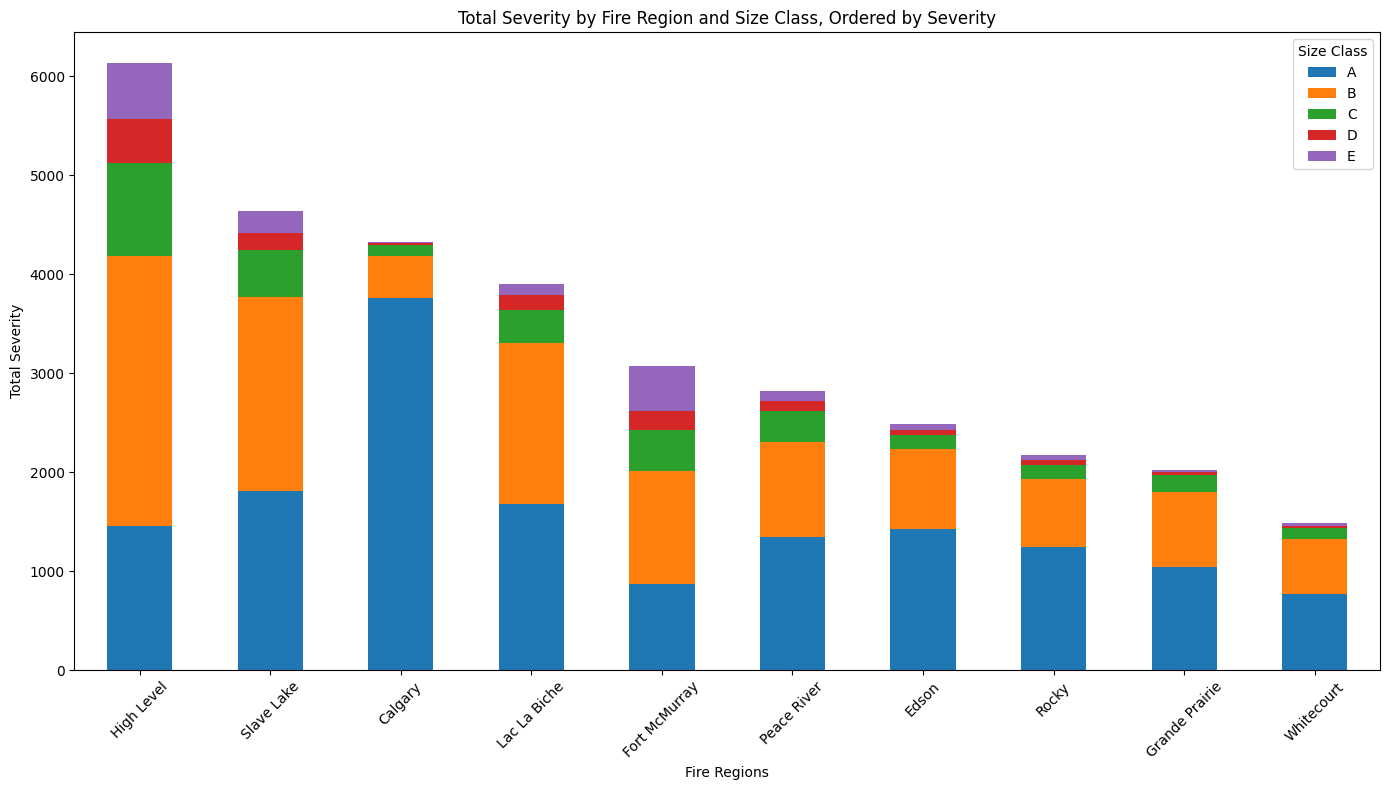

In [34]:

# Step 1: Group by 'fire_regions' and 'size_class', summing the severity
grouped_severity = df_fire_sev.groupby(['fire_regions', 'size_class'])['total_severity'].sum().reset_index()

# Step 2: Pivot the data
pivot_severity = grouped_severity.pivot(index='fire_regions', columns='size_class', values='total_severity').fillna(0)

# Calculate the total severity per region to sort
total_severity_per_region = pivot_severity.sum(axis=1)

# Sort the pivot table based on the total severity in descending order
pivot_severity_sorted = pivot_severity.loc[total_severity_per_region.sort_values(ascending=False).index]

# Create a color palette
palette = sns.color_palette("tab10", len(pivot_severity_sorted.columns))

# Step 3: Plotting with the sorted pivot table
plt.figure(figsize=(14, 8))
pivot_severity_sorted.plot(kind='bar', stacked=True, color=palette, figsize=(14, 8))

# Add labels and title
plt.xlabel('Fire Regions')
plt.ylabel('Total Severity')
plt.title('Total Severity by Fire Region and Size Class, Ordered by Severity')

# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Add a legend for the size classes
plt.legend(title='Size Class')

# Show the plot
plt.tight_layout()
plt.show()


In [35]:
pivot_severity.reset_index()

size_class,fire_regions,A,B,C,D,E
0,Calgary,3763,418,120,12,10
1,Edson,1423,808,144,56,60
2,Fort McMurray,869,1146,414,192,455
3,Grande Prairie,1038,758,177,24,20
4,High Level,1460,2730,939,440,570
5,Lac La Biche,1678,1630,333,152,105
6,Peace River,1345,964,312,96,100
7,Rocky,1243,684,150,44,55
8,Slave Lake,1813,1962,471,176,220
9,Whitecourt,770,550,120,16,30


### Plot - Average Severity by Fire Year for Specified Regions and Overall

In [36]:

# List of regions you want to plot (add or remove as needed)
specified_regions = ['High Level','Calgary', 'Fort McMurray', 'Slave Lake']  # Replace with regions of interest

C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\1169813283.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=region_data, x='fire_year', y='total_severity', label=region, ci=None)
C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\1169813283.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=region_data, x='fire_year', y='total_severity', label=region, ci=None)
C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\1169813283.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=region_data, x='fire_year', y='total_severity', label=region, ci=None)
C:\Users\paulp\AppData\Local\Temp\ipykernel_25632\1169813283.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=region_data, x='fire_year', y='total_severity', label=region, c

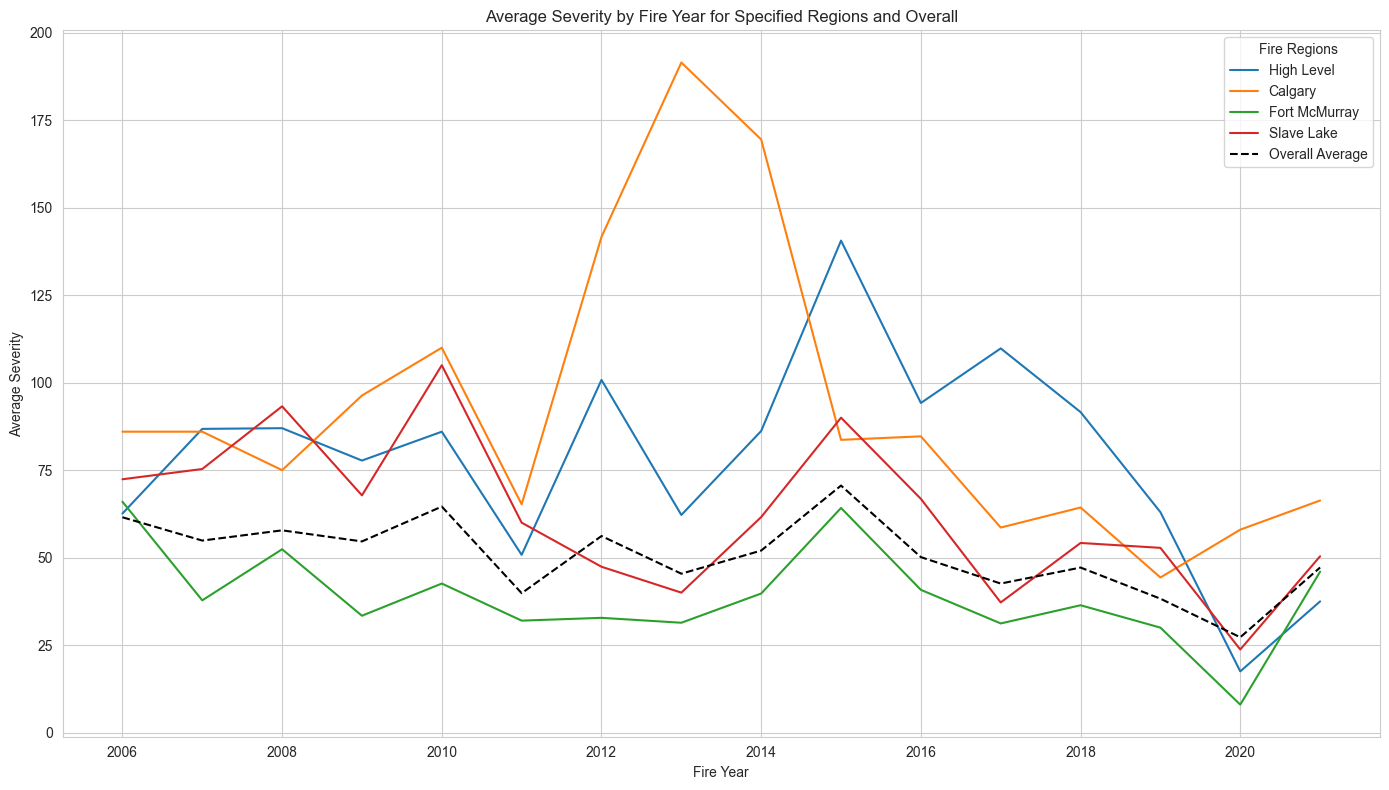

In [37]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Create a line plot for specified regions and the overall average
plt.figure(figsize=(14, 8))

for region in specified_regions:
    # Filter the data for the current region
    region_data = df_fire_sev[df_fire_sev['fire_regions'] == region]
    region_data = region_data.sort_values('fire_year')
    sns.lineplot(data=region_data, x='fire_year', y='total_severity', label=region, ci=None)

# Compute and plot the average severity for each year across all regions without the confidence interval shade
average_severity = df_fire_sev.groupby('fire_year')['total_severity'].mean().reset_index()
sns.lineplot(data=average_severity, x='fire_year', y='total_severity', label='Overall Average', color='black', linestyle='--', ci=None)

# Add labels and title
plt.xlabel('Fire Year')
plt.ylabel('Average Severity')
plt.title('Average Severity by Fire Year for Specified Regions and Overall')

# Add a legend to differentiate the regions from the overall average
plt.legend(title='Fire Regions')

# Show the plot
plt.tight_layout()
plt.show()

# Main Reasons of Fire, large burn areas, significant enviornmental and residential impact

1.  **Fire Number (fire_number):**

Uniquely identifies each wildfire incident, allowing for specific tracking and analysis of individual fires.

2.  **Current Size (current_size):**

Indicates the final area burned by the wildfire, essential for identifying fires with large burn areas and assessing their potential impact.

3.  **Size Class (size_class):**

Classifies wildfires based on the final area burned, helping to quickly identify the scale of wildfires (from very small to very large) for prioritization and analysis.

4.  **Fire Location Latitude & Longitude (fire_location_latitude, fire_location_longitude):**

Provides precise geographical coordinates of the wildfire's ignition point, crucial for mapping wildfires to specific FSA regions and analyzing spatial patterns of fire occurrence.

5.  **Fire Origin (fire_origin):**

Identifies who owns or administers the land where the wildfire started, which can impact the response strategy and potential resources available for firefighting efforts.


6.  **General Cause Description (general_cause_desc):**

Offers a broad classification of the wildfire's cause, useful for identifying general trends in wildfire ignition sources across different regions.

7.  **Industry Identifier Description (industry_identifier_desc):**

Gives further detail about the specific industry responsible for the wildfire when applicable, allowing for targeted measures in industries frequently associated with wildfire causes.

8.  **Responsible Group Description (responsible_group_desc):**

Specifies the group responsible for causing the wildfire, particularly relevant for fires started due to recreational activities, enabling targeted education and prevention efforts.

9.  **Activity Class (activity_class):**

Details the specific activity that led to the wildfire's ignition, providing insights into preventable behaviors or practices that may need regulation or awareness campaigns.

10. **True Cause (true_cause):**

Pinpoints the exact reason why the wildfire started, offering the most direct insight into preventable causes and potential areas for intervention.





https://colab.research.google.com/drive/18Azx41pldPjniUtvjTsO2-6v3hB_996Y?usp=sharing

more analysis is here.